<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [76]:
# Set your student number
student_number = 400100554
Name = 'Seyed Mohammad'
Last_Name = 'Ojagh kazzazi'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

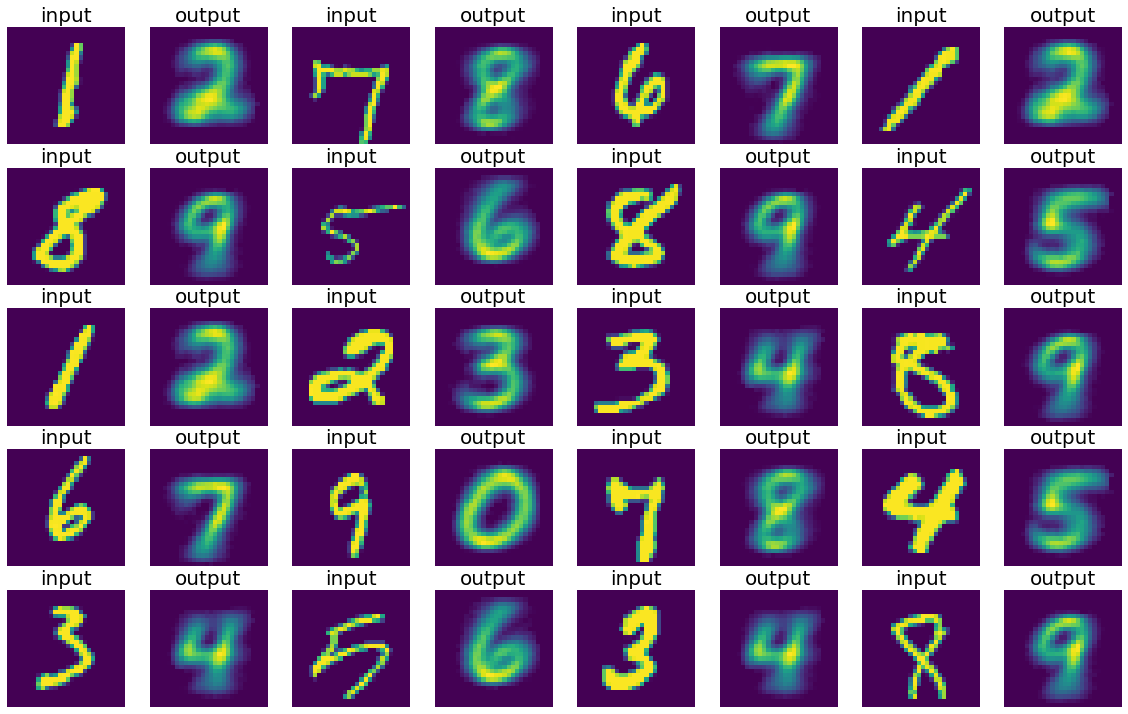

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [77]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [78]:
import torch
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [79]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X).float().unsqueeze(1)  
        self.Y = torch.tensor(Y).float().unsqueeze(1)
        self.y = torch.tensor(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [80]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'



def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> (float, float):
    model.to(device)
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    num_batches = len(dataloader)

    for batch in dataloader:
        X_batch, Y_batch, _ = batch
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        predictions = model(X_batch)  # Forward pass
        if predictions.shape != Y_batch.shape:
            raise ValueError(f"Shape mismatch: predictions shape {predictions.shape} and Y_batch shape {Y_batch.shape}")
        loss = nn.MSELoss()(predictions, Y_batch)  # Compute the loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate loss

        # Compute MAE for accuracy
        mae = nn.L1Loss()(predictions, Y_batch).item()
        total_mae += mae

    average_loss = total_loss / num_batches  # Calculate average loss
    average_mae = total_mae / num_batches  # Calculate average MAE
    accuracy = 1 - average_mae  # Simple proxy for accuracy
    return average_loss, accuracy

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> (float, float):
    model.to(device)
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    num_batches = len(dataloader)

    # Disable gradient calculations
    with torch.no_grad():
        for data in dataloader:
            X_batch, Y_batch, _ = data
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            # Forward pass
            reconstructed = model(X_batch)
            if reconstructed.shape != Y_batch.shape:
                raise ValueError(f"Shape mismatch: reconstructed shape {reconstructed.shape} and Y_batch shape {Y_batch.shape}")
            
            # Calculate the loss
            loss = nn.MSELoss()(reconstructed, Y_batch)
            
            # Aggregate the loss
            total_loss += loss.item()
            
            # Compute MAE for accuracy
            mae = nn.L1Loss()(reconstructed, Y_batch).item()
            total_mae += mae
    
    # Calculate the average loss
    average_loss = total_loss / num_batches
    average_mae = total_mae / num_batches  # Calculate average MAE
    accuracy = 1 - average_mae  # Simple proxy for accuracy
    return average_loss, accuracy

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [82]:
import torch.optim as optim 
ae = AutoEncoder().to(device=device)
optimizer = optim.Adam(ae.parameters(), lr=0.001)


## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [83]:
import logging
from torch.utils.data import DataLoader

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Training and validation loop
def train_and_validate(model, train_dataloader, val_dataloader, optimizer, num_epochs=15, patience=3):
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    patience_counter = 0
    epoch = 0

    while epoch < num_epochs:
        epoch += 1
        train_loss , train_acc = train_autoencoder(model, optimizer, train_dataloader)
        val_loss  , val_acc = eval_autoencoder(model, val_dataloader)

        # Save the state of the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        logging.info(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}")

        # Early stopping
        if patience_counter >= patience:
            logging.info(f"Early stopping at epoch {epoch}")
            break

    logging.info(f"Best epoch: {best_epoch}, Best validation loss: {best_val_loss:.4f}")
    return best_model_state

best_model_state = train_and_validate(ae, train_dataloader, val_dataloader, optimizer, num_epochs=15)


2024-06-05 13:18:32,173 - Epoch 1/15, Train Loss: 0.0693, train accuracy: 0.8395, Val Loss: 0.0634, Val accuracy: 0.8598
2024-06-05 13:19:11,063 - Epoch 2/15, Train Loss: 0.0610, train accuracy: 0.8604, Val Loss: 0.0599, Val accuracy: 0.8662
2024-06-05 13:19:55,957 - Epoch 3/15, Train Loss: 0.0587, train accuracy: 0.8652, Val Loss: 0.0584, Val accuracy: 0.8638
2024-06-05 13:20:36,394 - Epoch 4/15, Train Loss: 0.0578, train accuracy: 0.8672, Val Loss: 0.0575, Val accuracy: 0.8658
2024-06-05 13:21:16,578 - Epoch 5/15, Train Loss: 0.0572, train accuracy: 0.8684, Val Loss: 0.0573, Val accuracy: 0.8672
2024-06-05 13:21:57,042 - Epoch 6/15, Train Loss: 0.0568, train accuracy: 0.8692, Val Loss: 0.0568, Val accuracy: 0.8687
2024-06-05 13:22:37,287 - Epoch 7/15, Train Loss: 0.0565, train accuracy: 0.8699, Val Loss: 0.0568, Val accuracy: 0.8669
2024-06-05 13:23:17,518 - Epoch 8/15, Train Loss: 0.0564, train accuracy: 0.8703, Val Loss: 0.0566, Val accuracy: 0.8707
2024-06-05 13:23:58,726 - Epoch 

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [86]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
ae.load_state_dict(best_model_state)

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

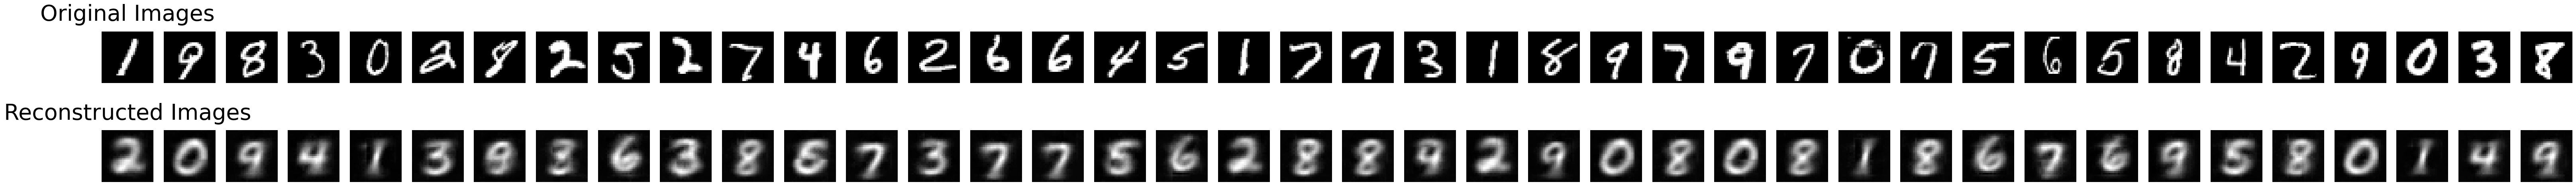

In [87]:
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch

# Convert the numpy arrays to PyTorch tensors
X_test_tensor = torch.from_numpy(X_test).float()

# If your test data doesn't have a channel dimension, add one
if len(X_test_tensor.shape) == 3:
    X_test_tensor = X_test_tensor.unsqueeze(1)

# Create a TensorDataset from the test data
test_dataset = TensorDataset(X_test_tensor)

# Define the test data loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Assuming test_loader is your test data loader
dataiter = iter(test_loader)
images = next(dataiter)

# Select 40 examples
images = images[0][:40]

# Move the images to the device where your model is
images = images.to(device)

# Get the model outputs
outputs = ae(images)

# Move the images and outputs back to cpu for visualization
images = images.cpu()
outputs = outputs.cpu()

fig, axes = plt.subplots(nrows=2, ncols=40, figsize=(80, 5))

# Input images on top row, and reconstructed images on bottom row
for i in range(40):
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(outputs[i].detach().squeeze(), cmap='gray')
    axes[1, i].axis('off')

# Add titles to the rows
axes[0, 0].set_title('Original Images', fontsize=40 , pad=20)
axes[1, 0].set_title('Reconstructed Images', fontsize=40, pad=20)
plt.subplots_adjust(hspace=0.8)


plt.show()